# Capstone Project : Customer Personality Analysis 
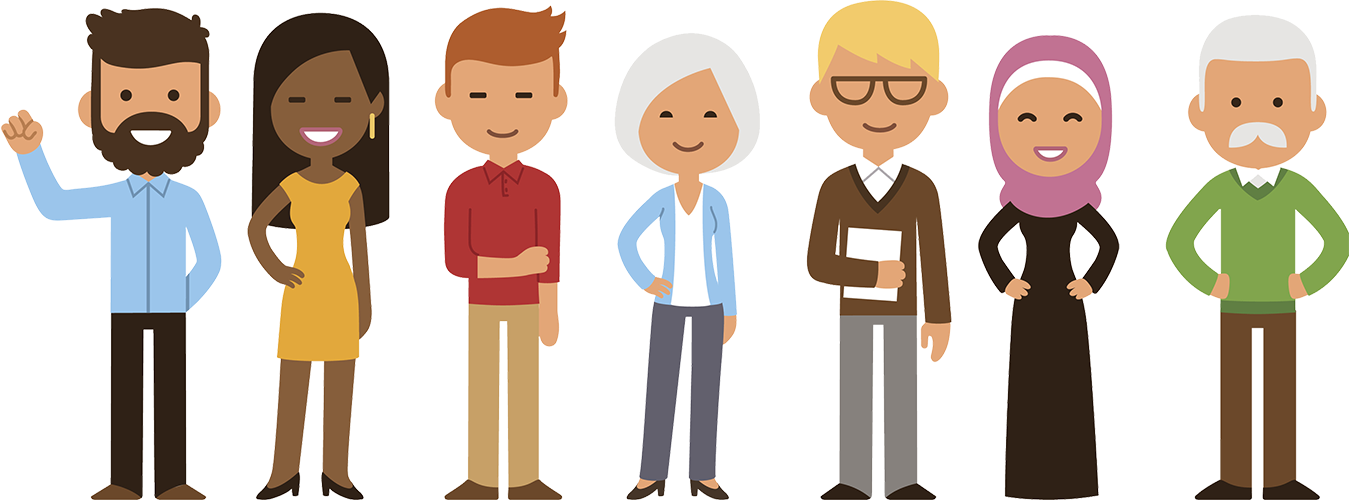
Customer Personality Analysis is a detailed analysis of a company's different types of customers. It helps the businesses to understand its customers and come up with the best sales and campaigns to serve them better. 
One example can be instead of spending money to market a new product to every customer in the database, it can analyze which segment is most likely to buy that product then market to them.
I will perform a clustering analysis on the customers Dataset. 
First I import the necessary libraries for data cleaning and clustering.

In [26]:
import os
import time
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

Then I set the Google Key path to read my data from the BigQuery  And check the information.


In [2]:
#set the google key path
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\faran\\Desktop\\Data Bootcamp\\capStone\\capstoneKey.json'
#a vaiable for my query
query = 'SELECT * FROM `capstoneproject-334219.customerData.slightlyCooked`'
#set the variables and 
client = bigquery.Client()
query_job = client.query(query)
#set some wait time for query to load
time.sleep(2)
#put results in a variable
result = query_job.result()
#call and load the raw dataset from bigQuery
slightlyCooked = result.to_dataframe()
#check the data
slightlyCooked.head(10)

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,Age,Children,totalMnt
0,4246,Master,Single,6560.0,0,0,2013-12-12,2,67,11,...,0,0,0,0,0,0,0,32,0,373
1,8720,2n Cycle,Together,NaN,0,0,2012-08-12,53,32,2,...,0,0,0,1,0,0,0,36,0,1679
2,1501,PhD,Married,160803.0,0,0,2012-08-04,21,55,16,...,0,0,0,0,0,0,0,32,0,1717
3,5336,Master,Together,157733.0,1,0,2013-06-04,37,39,1,...,0,0,0,0,0,0,0,43,1,59
4,4303,PhD,Together,6835.0,0,1,2012-12-08,76,107,2,...,0,0,0,0,0,0,0,57,1,137
5,1503,PhD,Together,162397.0,1,1,2013-06-03,31,85,1,...,0,0,0,0,0,0,0,38,2,107
6,6237,PhD,Single,7144.0,0,2,2013-12-07,92,81,4,...,0,0,0,0,0,0,0,48,2,416
7,5555,Graduation,Divorced,153924.0,0,0,2014-02-07,81,1,1,...,0,0,0,0,0,0,0,39,0,6
8,3955,Graduation,Divorced,4861.0,0,0,2014-06-22,20,2,1,...,0,0,0,0,0,0,0,49,0,6
9,11181,PhD,Married,156924.0,0,0,2013-08-29,85,2,1,...,0,0,0,0,0,0,0,65,0,8


### check the dataset
there is some null values in the "Income" columns. Expet "education", "marital_status" and "Dt_customer" the rest of the columns are numeric. 

In [3]:
slightlyCooked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntGoldProds         2240 non-null   int64  
 13  NumDealsPurchases    2240 non-null   int64  
 14  NumWebPurchases      2240 non-null   int64  
 15  NumCatalogPurchases  2240 non-null   i

## Cleaning and Feature Engineering
Although I added some columns with SQL, I need to clean the dataset further with python. I need to manage the null values, fix the "Marital_status" and "education" columns to change some irrelevant values. I will also calculate the total number of children and total amount of campaigns accepted and purchases.
In the end, I need to drop unnecessary columns for clustering.

### Dealing with null values
I drop the nulls because they are not a significant number.

In [4]:
#dropping null values in income column
df1 = slightlyCooked.dropna()
#getting the length after dropping the nulls
print(len(df1))
#getting a copy of dataset
df = df1.copy()

2216


### Fixing marital status and education
There is lots of values which basically are the same. so we change them to unique values.

In [5]:
#fixing marital status column
df['Marital_Status'] = df['Marital_Status'].replace(['Together','Married'],'Relationship')
df['Marital_Status'] = df['Marital_Status'].replace(['Single','Divorced','Widow','Alone','Absurd','YOLO'],'Single')
df['Marital_Status'].unique()

array(['Single', 'Relationship'], dtype=object)

In [6]:
# fixing education column
df['Education'] = df['Education'].replace(['PhD','Master','2n Cycle'],'Post Graduate')
df['Education'] = df['Education'].replace(['Graduation','Basic'],'Under Graduate')
df['Education'].unique()

array(['Post Graduate', 'Under Graduate'], dtype=object)

### Getting the total amount of children

In [7]:
#getting the amount of children at home
df['Children']= df['Kidhome'] + df['Teenhome']
df['Children'].unique()

array([0, 1, 2, 3], dtype=int64)

### Change the data type in Dt_costumer 

In [8]:
#change the dt_customer to date format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
#we assume the survey is taken in 2015
df['firstDate'] = pd.to_datetime('01-01-2015')
#New column to show the amount of days each customer enrolled 
df['daysEngaged'] = (df['firstDate'] - df['Dt_Customer']).dt.days

### Getting total amount of campaigns and purchases

In [9]:
# getting total amount of campaign
df['totalAccepted'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['totalAccepted'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
# getting total amount of Purchases
df['totalPurchase'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
df

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,AcceptedCmp5,Complain,Response,Age,Children,totalMnt,firstDate,daysEngaged,totalAccepted,totalPurchase
0,4246,Post Graduate,Single,6560.0,0,0,2013-12-12,2,67,11,...,0,0,0,32,0,373,2015-01-01,385,0,2
2,1501,Post Graduate,Relationship,160803.0,0,0,2012-08-04,21,55,16,...,0,0,0,32,0,1717,2015-01-01,880,0,44
3,5336,Post Graduate,Relationship,157733.0,1,0,2013-06-04,37,39,1,...,0,0,0,43,1,59,2015-01-01,576,0,2
4,4303,Post Graduate,Relationship,6835.0,0,1,2012-12-08,76,107,2,...,0,0,0,57,1,137,2015-01-01,754,0,1
5,1503,Post Graduate,Relationship,162397.0,1,1,2013-06-03,31,85,1,...,0,0,0,38,2,107,2015-01-01,577,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,6977,Under Graduate,Relationship,75702.0,0,1,2012-10-14,87,1073,0,...,1,0,0,40,1,1921,2015-01-01,809,1,29
2236,7488,Post Graduate,Single,64191.0,0,1,2013-01-22,30,420,15,...,0,0,0,51,1,825,2015-01-01,709,0,24
2237,10099,Under Graduate,Relationship,55434.0,1,0,2013-10-05,21,238,115,...,0,0,0,30,1,882,2015-01-01,453,0,24
2238,3828,Under Graduate,Relationship,71107.0,0,1,2013-02-17,61,533,10,...,0,0,0,63,1,1327,2015-01-01,683,0,28


### Dropping unnecessary columns
I will make the dataset smaller by omitting the columns that are not so related and also the ones that I already created their aggregates.

In [11]:
df.drop(['Kidhome','Teenhome', 'Dt_Customer', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'firstDate','ID'],axis=1,inplace=True)

df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'Complain',
       'Response', 'Age', 'Children', 'totalMnt', 'daysEngaged',
       'totalAccepted', 'totalPurchase'],
      dtype='object')

### Dealing with outliers
In case there are outliers in age and income I will set a cap for my dataset and remove the outliers.

In [12]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


### Finding object columns
I need to change the object columns to numeric to be able to use them in clustering

In [13]:
# Getting all the object columns
obj=[]
for i in df.columns:
    if(df[i].dtype =='object'):
        obj.append(i)
        
print(obj)

['Education', 'Marital_Status']


### Encoding the object columns
I need to use the one-hot encoding method to convert strings to 0 and 1s.

In [14]:
#encode the object columns
encode = preprocessing.LabelEncoder()
for i in obj:
    df[i]= encode.fit_transform(df[i])
    
df

,Education,Marital_Status,Income,Recency,Complain,Response,Age,Children,totalMnt,daysEngaged,totalAccepted,totalPurchase
0,0,1,6560.0,2,0,0,32,0,373,385,0,2
2,0,0,160803.0,21,0,0,32,0,1717,880,0,44
3,0,0,157733.0,37,0,0,43,1,59,576,0,2
4,0,0,6835.0,76,0,0,57,1,137,754,0,1
5,0,0,162397.0,31,0,0,38,2,107,577,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1,0,75702.0,87,0,0,40,1,1921,809,1,29
2236,0,1,64191.0,30,0,0,51,1,825,709,0,24
2237,1,0,55434.0,21,0,0,30,1,882,453,0,24
2238,1,0,71107.0,61,0,0,63,1,1327,683,0,28


### Scaling the Dataset
Feature scaling is essential for machine learning algorithms that calculate the distance between data. If not scale, the feature with a higher value range starts dominating when calculating distances. Clustering is one of these types of algorithms. Therefore I need to scale my data to fit the model.

In [15]:
# scale and standardized the values
scaled = StandardScaler()
dfValue = scaled.fit_transform(df.values)
dfModel = pd.DataFrame(dfValue, columns=df.columns)
dfModel

,Education,Marital_Status,Income,Recency,Complain,Response,Age,Children,totalMnt,daysEngaged,totalAccepted,totalPurchase
0,-1.058681,1.349603,-2.109374,-1.624914,-0.09552,-0.420977,-1.118591,-1.264598,-0.388906,-0.764213,-0.439160,-1.680792
1,-1.058681,-0.740959,5.057249,-0.968305,-0.09552,-0.420977,-1.118591,-1.264598,1.842254,1.680846,-0.439160,3.795163
2,-1.058681,-0.740959,4.914607,-0.415372,-0.09552,-0.420977,-0.178336,0.069987,-0.910174,0.179234,-0.439160,-1.680792
3,-1.058681,-0.740959,-2.096596,0.932403,-0.09552,-0.420977,1.018352,0.069987,-0.780687,1.058467,-0.439160,-1.811172
4,-1.058681,-0.740959,5.131311,-0.622722,-0.09552,-0.420977,-0.605725,1.404572,-0.830490,0.184173,-0.439160,-1.811172
...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0.944572,-0.740959,1.103184,1.312545,-0.09552,-0.420977,-0.434769,0.069987,2.180913,1.330140,1.032691,1.839464
2208,-1.058681,1.349603,0.568347,-0.657280,-0.09552,-0.420977,0.505486,0.069987,0.361454,0.836189,-0.439160,1.187565
2209,0.944572,-0.740959,0.161468,-0.968305,-0.09552,-0.420977,-1.289547,0.069987,0.456080,-0.428326,-0.439160,1.187565
2210,0.944572,-0.740959,0.889686,0.414028,-0.09552,-0.420977,1.531218,0.069987,1.194819,0.707762,-0.439160,1.709085


### Checking the correlations in different columns
We can see the number of purchases and income, as well as marital status and some others, are having high correlations.

<AxesSubplot:>

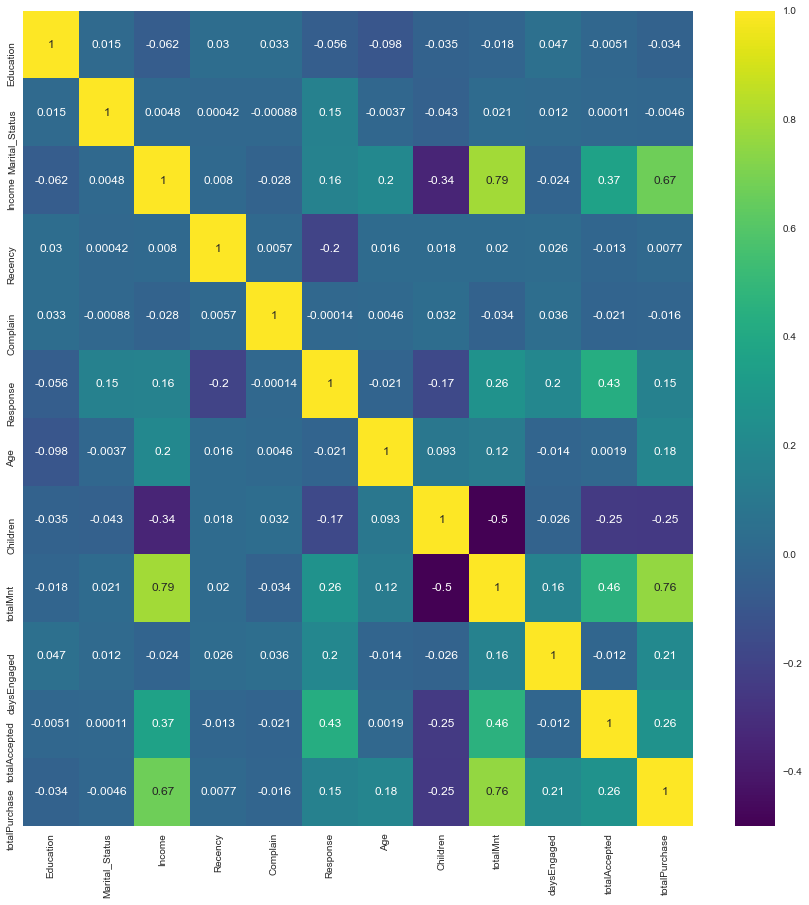

In [16]:
# Checking the correlations with a heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True, cmap='viridis')

### Dimensionality Reduction
It will reduce the time and processing power needed to run the model. It helps remove multi-collinearity and improves the interpretation of the parameters of the model.
For this study, I use the PCA algorithm. 


In [17]:
#Initiating PCA to reduce dimentions 3
pca = PCA(n_components=3)
#fitting the data
pca.fit(dfModel)
#transforming the data to 3 columns
PCA_df = pd.DataFrame(pca.transform(dfModel), columns=(['dim1','dim2', 'dim3']))
#describe the results
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
dim1,2212.0,1.788804e-15,1.766879,-2.831643,-1.620852,-0.278118,1.294012,5.377739
dim2,2212.0,-2.524603e-16,1.159408,-3.378159,-0.848311,-0.151217,0.655459,4.221372
dim3,2212.0,2.454336e-17,1.072445,-3.291070,-0.809221,-0.025272,0.780743,3.326733


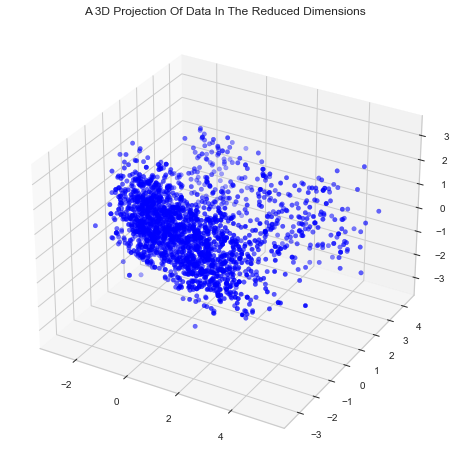

In [18]:
#A 3D Projection Of Data In The Reduced Dimensions
x =PCA_df['dim1']
y =PCA_df['dim2']
z =PCA_df['dim3']
#plotting the results 
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c='blue', marker='o')
ax.set_title('A 3D Projection Of Data In The Reduced Dimensions')
plt.show()

### Elbow method to find the optimal number of clusters
It seems 4 clusters is the best option.

Elbow Method to determine the number of clusters to be formed:


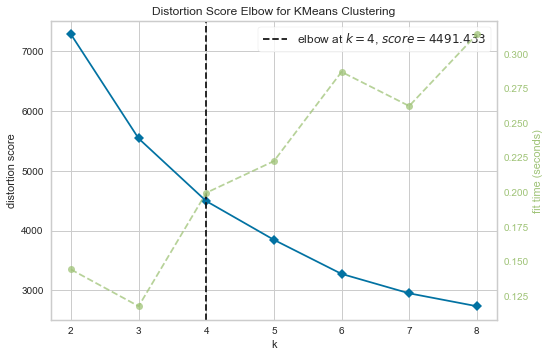

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
#elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=8)
Elbow_M.fit(PCA_df)
Elbow_M.show()

## Clustering

I did K-means clustering and also tried agglomerative clustering to see which model does a better job in clustering.I plotted each results to see if there is any difference.

### KMeans method:

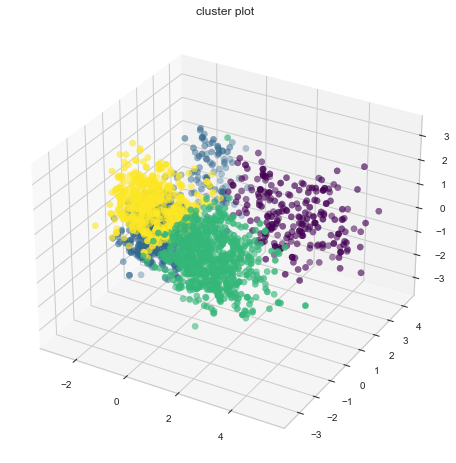

In [35]:
# setting the number of clusters
kmeans = KMeans(n_clusters=4)
# fit model
kmeans = kmeans.fit(PCA_df)
#predict clusters
clusters = kmeans.predict(PCA_df)
#creating columns
PCA_df['clusters'] = clusters
#Adding the Clusters feature to the original dataframe.
df['clusters']= clusters
# plotting the clusters 
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=PCA_df['clusters'], marker='o', cmap='viridis')
ax.set_title('cluster plot')
plt.show()

###  Agglomerative Clustering model 

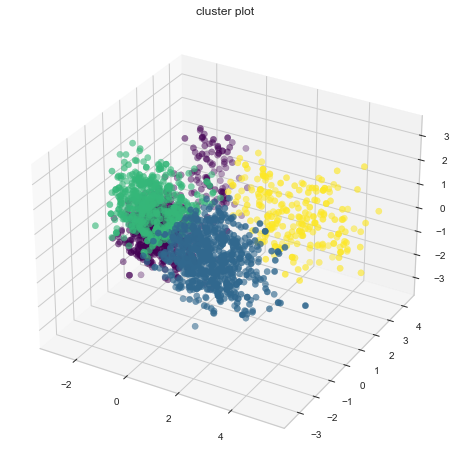

In [34]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
clusters2 = AC.fit_predict(PCA_df)
PCA_df['cluster'] = clusters2
#Adding the Cluster feature to the original dataframe.
df['cluster']= clusters2
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=PCA_df['cluster'], marker='o', cmap='viridis')
ax.set_title('cluster plot')
plt.show()

Both methods are looking similar. the location of each cluster is the same. The difference is only is cluster name designation. I can use either of them for my final analysis.
Next I will rename some values and make a csv to Use in Tableau for some cluster analysis.


## adjusting column values for using data in Tableau

In [ ]:
#replacing the values to object
df['Education'] = df['Education'].replace([0],'Post Graduate')
df['Education'] = df['Education'].replace([1],'Under Graduate')
# same for marital status
df['Marital_Status'] = df['Marital_Status'].replace([0],'Relationship')
df['Marital_Status'] = df['Marital_Status'].replace([1],'Single')
df

## Saving the dataset as csv to work with it further in Tableau

In [ ]:
#df.to_csv('C:/Users/faran/Desktop/Data Bootcamp/capStone/dataCust.csv')